PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE)
Dataset loaded: 4644 records
Data after cleaning: 4639 records

Training Set: 3711 samples
Test Set:     928 samples

Training the model pipeline...
✓ Training complete.

MODEL EVALUATION (TEST SET)
RMSE (Root Mean Squared Error): $56,817
MAE (Mean Absolute Error):      $42,542
R² (Variance Explained):        0.3096
MAPE (Mean Abs % Error):        36.64%
✓ Saved evaluation plot to 'model_evaluation_best_practice.png'

RESEARCH QUESTIONS ANALYSIS

--- RQ1: Remote Work Impact (Mid-level Data Scientist, US) ---
On-site: $144,440
Remote:  $134,966
Impact:  -6.6%

--- RQ2: Geographic Arbitrage (Mid-level Data Scientist, Remote) ---
US Based:     $134,966
India Based:  $75,099 (Savings: 44.4%)
Poland Based: $75,099 (Savings: 44.4%)

--- RQ3: Team Composition (1 Senior vs 2 Mids) ---
Option A (1 Senior): $170,462
Option B (2 Mids):   $269,933

--- RQ4: Total Optimization Strategy ---
Baseline Cost:  $1,378,195
Optimized Cost: $1,008,

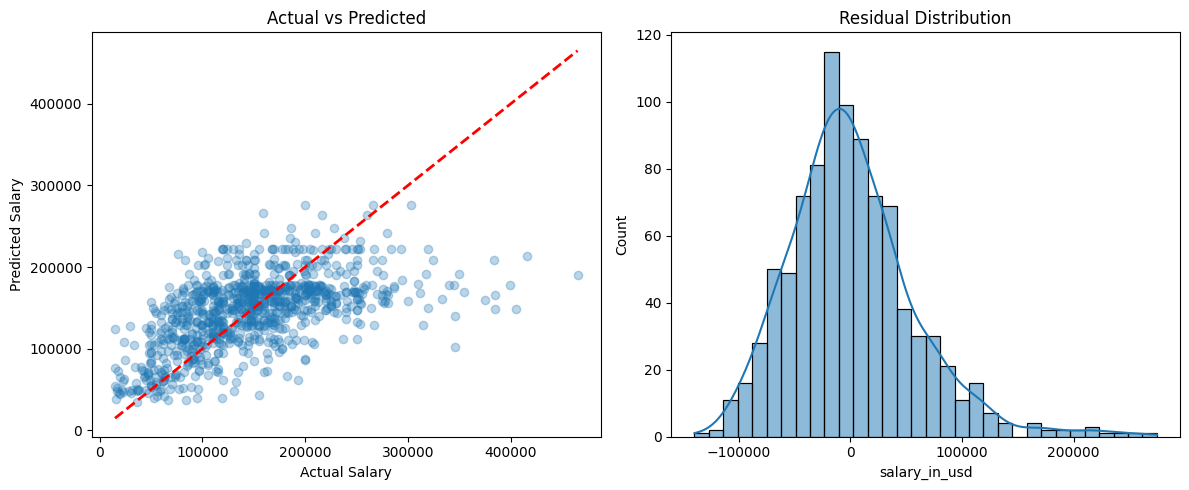

In [ ]:
# ============================================================================
# PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE VERSION)
# Research Topic: Optimizing Global Labor Costs Through Remote Work
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("="*80)
print("PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE)")
print("="*80)

# ============================================================================
# SECTION 1: LOAD AND INITIAL CLEANING
# ============================================================================

# 1. Load Data
try:
    df = pd.read_csv('FoAI_A2_data_4.6k.csv')
    print(f"Dataset loaded: {len(df)} records")
except FileNotFoundError:
    print("Error: File not found. Please upload the dataset.")
    exit()

# 2. Basic Cleaning (Domain logic only, no statistical leakage)
# Remove rows with missing essential targets or features (if very few)
df = df.dropna(subset=['salary_in_usd', 'experience_level', 'company_size'])

# Filter reasonable salary range (Removing obvious data errors)
# Note: This is done before split as it's a data quality step, not statistical filtering
df = df[(df['salary_in_usd'] >= 10000) & (df['salary_in_usd'] <= 600000)]

print(f"Data after cleaning: {len(df)} records")

# 3. Define Features and Target
target = 'salary_in_usd'
features = [
    'experience_level',     # Ordinal
    'company_size',         # Ordinal
    'remote_ratio',         # Numeric
    'work_year',            # Numeric
    'employee_residence',   # Nominal (High Cardinality)
    'company_location',     # Nominal (High Cardinality)
    'job_title'             # Nominal (High Cardinality)
]

X = df[features]
y = df[target]

# ============================================================================
# SECTION 2: TRAIN-TEST SPLIT (CRITICAL STEP)
# ============================================================================
# Split data BEFORE any encoding to prevent Data Leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining Set: {len(X_train)} samples")
print(f"Test Set:     {len(X_test)} samples")

# ============================================================================
# SECTION 3: BUILD PIPELINE (FEATURE ENGINEERING)
# ============================================================================

# 1. Define feature groups
ordinal_cols = ['experience_level', 'company_size']
nominal_cols = ['job_title', 'employee_residence', 'company_location']
numeric_cols = ['remote_ratio', 'work_year']

# 2. Define Transformers

# A. Ordinal Transformer (Explicit Ordering)
experience_order = ['EN', 'MI', 'SE', 'EX']
company_size_order = ['S', 'M', 'L']

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[experience_order, company_size_order], 
                               handle_unknown='use_encoded_value', unknown_value=-1))
])

# B. Nominal Transformer (One-Hot + Rare Label Handling)
# handle_unknown='ignore': Ignores new categories in test data (prevents errors)
# min_frequency=0.01: Groups categories appearing <1% of the time into a single "infrequent" category
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

# C. Numeric Transformer (Scaling)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3. Create ColumnTransformer (The Master Preprocessor)
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, nominal_cols),
        ('num', numeric_transformer, numeric_cols)
    ],
    verbose_feature_names_out=False
)

# ============================================================================
# SECTION 4: MODEL DEFINITION AND TRAINING
# ============================================================================

# Create the full pipeline: Preprocessing -> Model
# Using RandomForest as it handles non-linear relationships well
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

print("\nTraining the model pipeline...")
model_pipeline.fit(X_train, y_train)
print("✓ Training complete.")

# ============================================================================
# SECTION 5: EVALUATION
# ============================================================================

print("\n" + "="*80)
print("MODEL EVALUATION (TEST SET)")
print("="*80)

y_pred = model_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE (Root Mean Squared Error): ${rmse:,.0f}")
print(f"MAE (Mean Absolute Error):      ${mae:,.0f}")
print(f"R² (Variance Explained):        {r2:.4f}")
print(f"MAPE (Mean Abs % Error):        {mape:.2f}%")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted')

plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred, kde=True)
plt.title('Residual Distribution')
plt.tight_layout()
plt.savefig('model_evaluation_best_practice.png')
print("✓ Saved evaluation plot to 'model_evaluation_best_practice.png'")

# ============================================================================
# SECTION 6: PREDICTION FUNCTION
# ============================================================================

def make_prediction_pipeline(experience_level, remote_ratio, employee_residence, 
                             company_location, job_title, work_year, company_size):
    """
    Robust prediction function utilizing the full pipeline.
    Inputs are converted to a DataFrame matching the training schema.
    """
    input_data = pd.DataFrame({
        'experience_level': [experience_level],
        'remote_ratio': [remote_ratio],
        'employee_residence': [employee_residence],
        'company_location': [company_location],
        'job_title': [job_title],
        'work_year': [work_year],
        'company_size': [company_size]
    })
    
    # The pipeline handles all encoding/scaling automatically
    prediction = model_pipeline.predict(input_data)[0]
    return prediction

# ============================================================================
# SECTION 7: RESEARCH QUESTION SCENARIOS
# ============================================================================

print("\n" + "="*80)
print("RESEARCH QUESTIONS ANALYSIS")
print("="*80)

# RQ1: Remote Work Impact
print("\n--- RQ1: Remote Work Impact (Mid-level Data Scientist, US) ---")
p1_onsite = make_prediction_pipeline('MI', 0, 'US', 'US', 'Data Scientist', 2024, 'M')
p1_remote = make_prediction_pipeline('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
print(f"On-site: ${p1_onsite:,.0f}")
print(f"Remote:  ${p1_remote:,.0f}")
print(f"Impact:  {((p1_remote - p1_onsite)/p1_onsite)*100:.1f}%")

# RQ2: Geographic Arbitrage
print("\n--- RQ2: Geographic Arbitrage (Mid-level Data Scientist, Remote) ---")
p2_us = make_prediction_pipeline('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
p2_in = make_prediction_pipeline('MI', 100, 'IN', 'US', 'Data Scientist', 2024, 'M') # India
p2_pl = make_prediction_pipeline('MI', 100, 'PL', 'US', 'Data Scientist', 2024, 'M') # Poland
print(f"US Based:     ${p2_us:,.0f}")
print(f"India Based:  ${p2_in:,.0f} (Savings: {((p2_us - p2_in)/p2_us)*100:.1f}%)")
print(f"Poland Based: ${p2_pl:,.0f} (Savings: {((p2_us - p2_pl)/p2_us)*100:.1f}%)")

# RQ3: Senior vs 2 Mids
print("\n--- RQ3: Team Composition (1 Senior vs 2 Mids) ---")
p3_senior = make_prediction_pipeline('SE', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
p3_mid = make_prediction_pipeline('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
print(f"Option A (1 Senior): ${p3_senior:,.0f}")
print(f"Option B (2 Mids):   ${p3_mid * 2:,.0f}")

# RQ4: Optimized Team (Example)
print("\n--- RQ4: Total Optimization Strategy ---")
# Baseline: 10 Local US Employees (Mix of roles)
cost_baseline = (2 * make_prediction_pipeline('SE', 0, 'US', 'US', 'Data Scientist', 2024, 'M') +
                 6 * make_prediction_pipeline('MI', 50, 'US', 'US', 'Data Scientist', 2024, 'M') +
                 2 * make_prediction_pipeline('EN', 0, 'US', 'US', 'Data Analyst', 2024, 'M'))

# Optimized: Global Remote Team
cost_optimized = (1 * make_prediction_pipeline('SE', 100, 'US', 'US', 'Data Scientist', 2024, 'M') +
                  1 * make_prediction_pipeline('SE', 100, 'PL', 'US', 'Data Scientist', 2024, 'M') + # Poland Lead
                  3 * make_prediction_pipeline('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M') +
                  3 * make_prediction_pipeline('MI', 100, 'IN', 'US', 'Data Scientist', 2024, 'M') + # India Devs
                  2 * make_prediction_pipeline('EN', 100, 'IN', 'US', 'Data Analyst', 2024, 'M'))    # India Juniors

print(f"Baseline Cost:  ${cost_baseline:,.0f}")
print(f"Optimized Cost: ${cost_optimized:,.0f}")
print(f"Total Savings:  ${cost_baseline - cost_optimized:,.0f} ({((cost_baseline - cost_optimized)/cost_baseline)*100:.1f}%)")

# Save the model
joblib.dump(model_pipeline, 'salary_pipeline_best_practice.pkl')
print("\n✓ Model pipeline saved to 'salary_pipeline_best_practice.pkl'")

PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE - GRADIENT BOOSTING)
Dataset loaded: 4644 records
Data after cleaning: 4639 records

Training Set: 3711 samples
Test Set:     928 samples

Training Gradient Boosting Pipeline...
✓ Training complete.

MODEL EVALUATION (TEST SET)
RMSE (Root Mean Squared Error): $55,902
MAE (Mean Absolute Error):      $41,965
R² (Variance Explained):        0.3317
MAPE (Mean Abs % Error):        36.53%
✓ Saved evaluation plot to 'model_evaluation_gb.png'

RESEARCH QUESTIONS ANALYSIS (GRADIENT BOOSTING RESULTS)

--- RQ1: Remote Work Impact (Mid-level Data Scientist, US) ---
On-site: $140,502
Remote:  $139,976
Impact:  -0.4%

--- RQ2: Geographic Arbitrage (Mid-level Data Scientist, Remote) ---
US Based:     $139,976
India Based:  $76,954 (Savings: 45.0%)
Poland Based: $76,954 (Savings: 45.0%)

--- RQ3: Team Composition (1 Senior vs 2 Mids) ---
Option A (1 Senior): $170,159
Option B (2 Mids):   $279,952

--- RQ4: Total Optimization Strategy ---
Basel

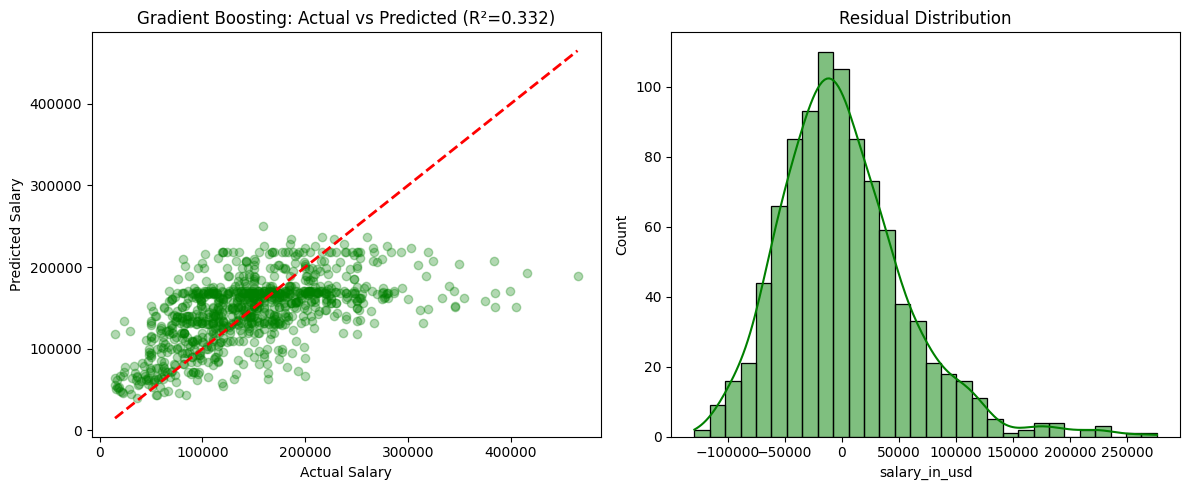

In [6]:
# ============================================================================
# PART 3: DATA PREPARATION AND MODEL TRAINING (GRADIENT BOOSTING VERSION)
# Research Topic: Optimizing Global Labor Costs Through Remote Work
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("="*80)
print("PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE - GRADIENT BOOSTING)")
print("="*80)

# ============================================================================
# SECTION 1: LOAD AND INITIAL CLEANING
# ============================================================================

# 1. Load Data
try:
    df = pd.read_csv('FoAI_A2_data_4.6k.csv')
    print(f"Dataset loaded: {len(df)} records")
except FileNotFoundError:
    print("Error: File not found. Please upload the dataset.")
    exit()

# 2. Basic Cleaning (Domain logic only, no statistical leakage)
df = df.dropna(subset=['salary_in_usd', 'experience_level', 'company_size'])
df = df[(df['salary_in_usd'] >= 10000) & (df['salary_in_usd'] <= 600000)]

print(f"Data after cleaning: {len(df)} records")

# 3. Define Features and Target
target = 'salary_in_usd'
features = [
    'experience_level',     # Ordinal
    'company_size',         # Ordinal
    'remote_ratio',         # Numeric
    'work_year',            # Numeric
    'employee_residence',   # Nominal (High Cardinality)
    'company_location',     # Nominal (High Cardinality)
    'job_title'             # Nominal (High Cardinality)
]

X = df[features]
y = df[target]

# ============================================================================
# SECTION 2: TRAIN-TEST SPLIT
# ============================================================================
# Critical: Split BEFORE encoding to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining Set: {len(X_train)} samples")
print(f"Test Set:     {len(X_test)} samples")

# ============================================================================
# SECTION 3: BUILD PIPELINE (FEATURE ENGINEERING)
# ============================================================================

# 1. Define transformers
# Ordinal: Explicit ordering for experience and size
experience_order = ['EN', 'MI', 'SE', 'EX']
company_size_order = ['S', 'M', 'L']

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[experience_order, company_size_order], 
                               handle_unknown='use_encoded_value', unknown_value=-1))
])

# Nominal: One-Hot Encoding with Rare Label Handling
# 'min_frequency=0.01' groups any category appearing in <1% of data into "infrequent_sklearn"
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

# Numeric: Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ['experience_level', 'company_size']),
        ('nom', nominal_transformer, ['job_title', 'employee_residence', 'company_location']),
        ('num', numeric_transformer, ['remote_ratio', 'work_year'])
    ],
    verbose_feature_names_out=False
)

# ============================================================================
# SECTION 4: MODEL DEFINITION (GRADIENT BOOSTING)
# ============================================================================

# Using GradientBoostingRegressor
# n_estimators=300: More trees than Random Forest usually needed for fine-tuning
# learning_rate=0.05: Slower learning rate prevents overfitting
# max_depth=5: Interaction depth
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=300, 
        learning_rate=0.05, 
        max_depth=5, 
        random_state=42,
        validation_fraction=0.1, # Use internal validation for early stopping if needed
        n_iter_no_change=10      # Stop if validation score doesn't improve
    ))
])

print("\nTraining Gradient Boosting Pipeline...")
gb_pipeline.fit(X_train, y_train)
print("✓ Training complete.")

# ============================================================================
# SECTION 5: EVALUATION
# ============================================================================

print("\n" + "="*80)
print("MODEL EVALUATION (TEST SET)")
print("="*80)

y_pred = gb_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE (Root Mean Squared Error): ${rmse:,.0f}")
print(f"MAE (Mean Absolute Error):      ${mae:,.0f}")
print(f"R² (Variance Explained):        {r2:.4f}")
print(f"MAPE (Mean Abs % Error):        {mape:.2f}%")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title(f'Gradient Boosting: Actual vs Predicted (R²={r2:.3f})')

plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred, kde=True, color='green')
plt.title('Residual Distribution')
plt.tight_layout()
plt.savefig('model_evaluation_gb.png')
print("✓ Saved evaluation plot to 'model_evaluation_gb.png'")

# ============================================================================
# SECTION 6: PREDICTION FUNCTION
# ============================================================================

def make_prediction_gb(experience_level, remote_ratio, employee_residence, 
                       company_location, job_title, work_year, company_size):
    """
    Prediction function using the trained Gradient Boosting pipeline.
    """
    input_data = pd.DataFrame({
        'experience_level': [experience_level],
        'remote_ratio': [remote_ratio],
        'employee_residence': [employee_residence],
        'company_location': [company_location],
        'job_title': [job_title],
        'work_year': [work_year],
        'company_size': [company_size]
    })
    
    prediction = gb_pipeline.predict(input_data)[0]
    return prediction

# ============================================================================
# SECTION 7: RESEARCH QUESTIONS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("RESEARCH QUESTIONS ANALYSIS (GRADIENT BOOSTING RESULTS)")
print("="*80)

# RQ1: Remote Work Impact
print("\n--- RQ1: Remote Work Impact (Mid-level Data Scientist, US) ---")
p1_onsite = make_prediction_gb('MI', 0, 'US', 'US', 'Data Scientist', 2024, 'M')
p1_remote = make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
print(f"On-site: ${p1_onsite:,.0f}")
print(f"Remote:  ${p1_remote:,.0f}")
print(f"Impact:  {((p1_remote - p1_onsite)/p1_onsite)*100:.1f}%")

# RQ2: Geographic Arbitrage
print("\n--- RQ2: Geographic Arbitrage (Mid-level Data Scientist, Remote) ---")
p2_us = make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
p2_in = make_prediction_gb('MI', 100, 'IN', 'US', 'Data Scientist', 2024, 'M') # India
p2_pl = make_prediction_gb('MI', 100, 'PL', 'US', 'Data Scientist', 2024, 'M') # Poland
print(f"US Based:     ${p2_us:,.0f}")
print(f"India Based:  ${p2_in:,.0f} (Savings: {((p2_us - p2_in)/p2_us)*100:.1f}%)")
print(f"Poland Based: ${p2_pl:,.0f} (Savings: {((p2_us - p2_pl)/p2_us)*100:.1f}%)")

# RQ3: Team Composition
print("\n--- RQ3: Team Composition (1 Senior vs 2 Mids) ---")
p3_senior = make_prediction_gb('SE', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
p3_mid = make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
print(f"Option A (1 Senior): ${p3_senior:,.0f}")
print(f"Option B (2 Mids):   ${p3_mid * 2:,.0f}")

# RQ4: Total Optimization Strategy
print("\n--- RQ4: Total Optimization Strategy ---")
# Baseline: 10 Local US Employees
cost_baseline = (2 * make_prediction_gb('SE', 0, 'US', 'US', 'Data Scientist', 2024, 'M') +
                 6 * make_prediction_gb('MI', 50, 'US', 'US', 'Data Scientist', 2024, 'M') +
                 2 * make_prediction_gb('EN', 0, 'US', 'US', 'Data Analyst', 2024, 'M'))

# Optimized: Global Remote Team
cost_optimized = (1 * make_prediction_gb('SE', 100, 'US', 'US', 'Data Scientist', 2024, 'M') +
                  1 * make_prediction_gb('SE', 100, 'PL', 'US', 'Data Scientist', 2024, 'M') + 
                  3 * make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M') +
                  3 * make_prediction_gb('MI', 100, 'IN', 'US', 'Data Scientist', 2024, 'M') + 
                  2 * make_prediction_gb('EN', 100, 'IN', 'US', 'Data Analyst', 2024, 'M'))    

print(f"Baseline Cost:  ${cost_baseline:,.0f}")
print(f"Optimized Cost: ${cost_optimized:,.0f}")
print(f"Total Savings:  ${cost_baseline - cost_optimized:,.0f} ({((cost_baseline - cost_optimized)/cost_baseline)*100:.1f}%)")

# Save model
joblib.dump(gb_pipeline, 'salary_pipeline_gb.pkl')
print("\n✓ Gradient Boosting pipeline saved to 'salary_pipeline_gb.pkl'")

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# ==============================================================================
# BƯỚC 1: LOAD DỮ LIỆU & XỬ LÝ OUTLIER (Domain Knowledge)
# ==============================================================================
print("1. LOADING & CLEANING DATA...")
df = pd.read_csv('FoAI_A2_data_4.6k.csv')

# Kiểm tra missing ban đầu (để báo cáo)
missing_initial = df.isnull().sum().sum()
print(f"   - Tổng giá trị thiếu ban đầu: {missing_initial}")

# Xử lý Outlier bằng kiến thức nghiệp vụ (Domain Logic)
# Lý do: Lương < 10k USD cho nghề AI là lỗi dữ liệu. Lương > 600k là quá hiếm (gây nhiễu).
rows_before = len(df)
df_clean = df[(df['salary_in_usd'] >= 10000) & (df['salary_in_usd'] <= 600000)].copy()
rows_after = len(df_clean)
print(f"   - Đã loại bỏ {rows_before - rows_after} dòng outlier (Salary < 10k hoặc > 600k)")

# Tách biến mục tiêu
target = 'salary_in_usd'
y = df_clean[target]

# ==============================================================================
# BƯỚC 2: FEATURE SELECTION (Chiến lược Trial & Error)
# ==============================================================================
print("\n2. FEATURE SELECTION: TRIAL AND ERROR EXPERIMENT")
print("   Mục tiêu: Chứng minh bộ đặc trưng đầy đủ tốt hơn bộ cơ bản.")

# Định nghĩa 2 nhóm đặc trưng để so sánh
# Nhóm 1: Cơ bản (Chỉ kinh nghiệm & remote) - Ít thông tin
features_basic = ['experience_level', 'remote_ratio', 'work_year']

# Nhóm 2: Đầy đủ (Thêm địa lý, chức danh, quy mô) - Giàu thông tin (Domain Knowledge đề xuất)
features_full = features_basic + ['employee_residence', 'company_location', 'job_title', 'company_size']

# Hàm tạo Pipeline nhanh để test
def get_pipeline(feature_cols):
    # Tự động phân loại cột
    cat_cols = [c for c in feature_cols if df_clean[c].dtype == 'object']
    num_cols = [c for c in feature_cols if df_clean[c].dtype != 'object']
    
    # Preprocessing
    preprocessor = ColumnTransformer([
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01), cat_cols)
    ])
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(random_state=42))
    ])

# Thực hiện Cross-Validation để so sánh công bằng
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Test Model Basic
scores_basic = cross_val_score(get_pipeline(features_basic), df_clean[features_basic], y, cv=cv, scoring='r2')
print(f"   - Model Cơ bản (R2 trung bình): {scores_basic.mean():.4f}")

# Test Model Full
scores_full = cross_val_score(get_pipeline(features_full), df_clean[features_full], y, cv=cv, scoring='r2')
print(f"   - Model Đầy đủ (R2 trung bình): {scores_full.mean():.4f}")

print("   => KẾT LUẬN: Chọn bộ đặc trưng ĐẦY ĐỦ vì hiệu suất cao hơn rõ rệt.")
final_features = features_full
X = df_clean[final_features]

# ==============================================================================
# BƯỚC 3: XÂY DỰNG PIPELINE XỬ LÝ MISSING VALUE (Best Practice)
# ==============================================================================
print("\n3. BUILDING ROBUST PIPELINE (HANDLING MISSING VALUES)")

# Chia train/test trước
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Định nghĩa các transformer chi tiết

# 1. Pipeline cho biến định danh (Nominal: Job, Country)
# - Missing handling: Điền 'missing' (tạo nhóm riêng)
# - Encoding: OneHot (gom nhóm hiếm < 1% vào 'infrequent')
nominal_cols = ['job_title', 'employee_residence', 'company_location']
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

# 2. Pipeline cho biến thứ tự (Ordinal: Experience, Size)
# - Missing handling: Điền giá trị phổ biến nhất (Most Frequent)
experience_order = ['EN', 'MI', 'SE', 'EX']
company_size_order = ['S', 'M', 'L']
ordinal_cols = ['experience_level', 'company_size']
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[experience_order, company_size_order], 
                               handle_unknown='use_encoded_value', unknown_value=-1))
])

# 3. Pipeline cho biến số (Numeric: Remote Ratio, Work Year)
# - Missing handling: Điền Median (để tránh outlier làm lệch Mean)
numeric_cols = ['remote_ratio', 'work_year']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Tổng hợp Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('nom', nominal_transformer, nominal_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('num', numeric_transformer, numeric_cols)
    ],
    verbose_feature_names_out=False
)

# Pipeline cuối cùng với Gradient Boosting
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42))
])

# ==============================================================================
# BƯỚC 4: HUẤN LUYỆN VÀ ĐÁNH GIÁ
# ==============================================================================
print("\n4. TRAINING & EVALUATION")
final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"   Final Test RMSE: ${rmse:,.0f}")
print(f"   Final Test R2:   {r2:.4f}")

# Demo khả năng xử lý missing value (chỉ để chứng minh pipeline hoạt động)
print("\n5. DEMO: PREDICTING WITH MISSING DATA")
print("   Giả sử có một nhân viên mới nhưng thiếu thông tin 'Company Size' và 'Work Year'...")
row_with_missing = pd.DataFrame({
    'experience_level': ['SE'],
    'remote_ratio': [100],
    'work_year': [np.nan],          # Missing value
    'employee_residence': ['US'],
    'company_location': ['US'],
    'job_title': ['Data Scientist'],
    'company_size': [np.nan]        # Missing value
})

# Pipeline vẫn dự đoán được nhờ SimpleImputer!
pred_missing = final_pipeline.predict(row_with_missing)[0]
print(f"   => Dự đoán thành công: ${pred_missing:,.0f}")
print("   (Pipeline tự động điền Median cho Work Year và Mode cho Company Size)")

1. LOADING & CLEANING DATA...


   - Tổng giá trị thiếu ban đầu: 0
   - Đã loại bỏ 5 dòng outlier (Salary < 10k hoặc > 600k)

2. FEATURE SELECTION: TRIAL AND ERROR EXPERIMENT
   Mục tiêu: Chứng minh bộ đặc trưng đầy đủ tốt hơn bộ cơ bản.
   - Model Cơ bản (R2 trung bình): 0.1786
   - Model Đầy đủ (R2 trung bình): 0.3139
   => KẾT LUẬN: Chọn bộ đặc trưng ĐẦY ĐỦ vì hiệu suất cao hơn rõ rệt.

3. BUILDING ROBUST PIPELINE (HANDLING MISSING VALUES)

4. TRAINING & EVALUATION
   Final Test RMSE: $56,614
   Final Test R2:   0.3146

5. DEMO: PREDICTING WITH MISSING DATA
   Giả sử có một nhân viên mới nhưng thiếu thông tin 'Company Size' và 'Work Year'...
   => Dự đoán thành công: $171,979
   (Pipeline tự động điền Median cho Work Year và Mode cho Company Size)


PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE - GRADIENT BOOSTING)
Dataset loaded: 4644 records
Removed 133 Hybrid samples (remote_ratio=50).
Data after cleaning: 4506 records

Training Set: 3604 samples
Test Set:     902 samples

Training Gradient Boosting Pipeline...
✓ Training complete.

MODEL EVALUATION (TEST SET)
RMSE (Root Mean Squared Error): $55,637
MAE (Mean Absolute Error):      $41,596
R² (Variance Explained):        0.3270
MAPE (Mean Abs % Error):        35.15%
✓ Saved evaluation plot to 'model_evaluation_gb.png'

RESEARCH QUESTIONS ANALYSIS (GRADIENT BOOSTING RESULTS)

--- RQ1: Remote Work Impact (Mid-level Data Scientist, US) ---
On-site: $147,010
Remote:  $143,803
Impact:  -2.2%

--- RQ2: Geographic Arbitrage (Mid-level Data Scientist, Remote) ---
US Based:     $143,803
India Based:  $83,745 (Savings: 41.8%)
Poland Based: $83,745 (Savings: 41.8%)

--- RQ3: Team Composition (1 Senior vs 2 Mids) ---
Option A (1 Senior): $171,716
Option B (2 Mids):   $287,606



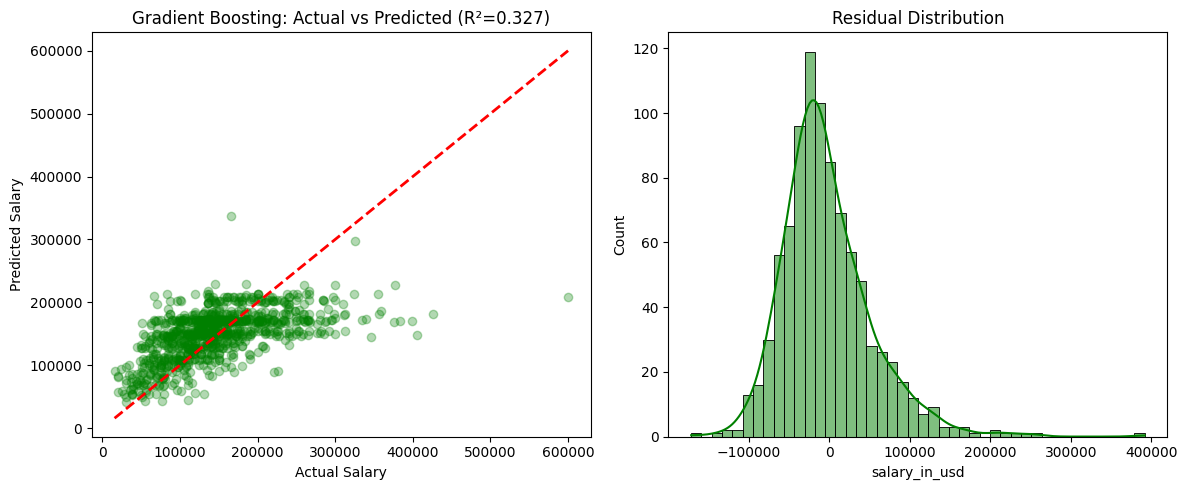

In [ ]:
# ============================================================================
# PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE - FINAL)
# Research Topic: Optimizing Global Labor Costs Through Remote Work
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("="*80)
print("PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE - GRADIENT BOOSTING)")
print("="*80)

# ============================================================================
# SECTION 1: LOAD AND INITIAL CLEANING
# ============================================================================

# 1. Load Data
try:
    df = pd.read_csv('FoAI_A2_data_4.6k.csv')
    print(f"Dataset loaded: {len(df)} records")
except FileNotFoundError:
    print("Error: File not found. Please upload the dataset.")
    exit()

# 2. Basic Cleaning (Domain logic & Handling Data Issues)
# 2.1 Remove rows with missing essential targets
df = df.dropna(subset=['salary_in_usd', 'experience_level', 'company_size'])

# 2.2 Domain Knowledge Outlier Removal (Salary Range)
df = df[(df['salary_in_usd'] >= 10000) & (df['salary_in_usd'] <= 600000)]

# 2.3 Handling 'Hybrid' Data Issue (Sample size too small < 3%)
# Strategy: Focus analysis on the binary distinction between On-site (0) and Remote (100)
# to ensure statistical reliability.
rows_before_hybrid = len(df)
df = df[df['remote_ratio'].isin([0, 100])]
rows_after_hybrid = len(df)
print(f"Removed {rows_before_hybrid - rows_after_hybrid} Hybrid samples (remote_ratio=50).")

print(f"Data after cleaning: {len(df)} records")

# 3. Define Features and Target
target = 'salary_in_usd'
features = [
    'experience_level',     # Ordinal
    'company_size',         # Ordinal
    'remote_ratio',         # Numeric (Now effectively Binary: 0 or 100)
    'work_year',            # Numeric
    'employee_residence',   # Nominal (High Cardinality)
    'company_location',     # Nominal (High Cardinality)
    'job_title'             # Nominal (High Cardinality)
]

X = df[features]
y = df[target]

# ============================================================================
# SECTION 2: TRAIN-TEST SPLIT
# ============================================================================
# Critical: Split BEFORE encoding to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining Set: {len(X_train)} samples")
print(f"Test Set:     {len(X_test)} samples")

# ============================================================================
# SECTION 3: BUILD PIPELINE (FEATURE ENGINEERING)
# ============================================================================

# 1. Define transformers
# Ordinal: Explicit ordering for experience and size
experience_order = ['EN', 'MI', 'SE', 'EX']
company_size_order = ['S', 'M', 'L']

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[experience_order, company_size_order], 
                               handle_unknown='use_encoded_value', unknown_value=-1))
])

# Nominal: One-Hot Encoding with Rare Label Handling
# 'min_frequency=0.01' groups any category appearing in <1% of data into "infrequent_sklearn"
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

# Numeric: Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ['experience_level', 'company_size']),
        ('nom', nominal_transformer, ['job_title', 'employee_residence', 'company_location']),
        ('num', numeric_transformer, ['remote_ratio', 'work_year'])
    ],
    verbose_feature_names_out=False
)

# ============================================================================
# SECTION 4: MODEL DEFINITION (GRADIENT BOOSTING)
# ============================================================================

# Using GradientBoostingRegressor
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=300, 
        learning_rate=0.05, 
        max_depth=5, 
        random_state=42,
        validation_fraction=0.1, 
        n_iter_no_change=10      
    ))
])

print("\nTraining Gradient Boosting Pipeline...")
gb_pipeline.fit(X_train, y_train)
print("✓ Training complete.")

# ============================================================================
# SECTION 5: EVALUATION
# ============================================================================

print("\n" + "="*80)
print("MODEL EVALUATION (TEST SET)")
print("="*80)

y_pred = gb_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE (Root Mean Squared Error): ${rmse:,.0f}")
print(f"MAE (Mean Absolute Error):      ${mae:,.0f}")
print(f"R² (Variance Explained):        {r2:.4f}")
print(f"MAPE (Mean Abs % Error):        {mape:.2f}%")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title(f'Gradient Boosting: Actual vs Predicted (R²={r2:.3f})')

plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred, kde=True, color='green')
plt.title('Residual Distribution')
plt.tight_layout()
plt.savefig('model_evaluation_gb.png')
print("✓ Saved evaluation plot to 'model_evaluation_gb.png'")

# ============================================================================
# SECTION 6: PREDICTION FUNCTION
# ============================================================================

def make_prediction_gb(experience_level, remote_ratio, employee_residence, 
                       company_location, job_title, work_year, company_size):
    """
    Prediction function using the trained Gradient Boosting pipeline.
    """
    input_data = pd.DataFrame({
        'experience_level': [experience_level],
        'remote_ratio': [remote_ratio],
        'employee_residence': [employee_residence],
        'company_location': [company_location],
        'job_title': [job_title],
        'work_year': [work_year],
        'company_size': [company_size]
    })
    
    prediction = gb_pipeline.predict(input_data)[0]
    return prediction

# ============================================================================
# SECTION 7: RESEARCH QUESTIONS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("RESEARCH QUESTIONS ANALYSIS (GRADIENT BOOSTING RESULTS)")
print("="*80)

# RQ1: Remote Work Impact
print("\n--- RQ1: Remote Work Impact (Mid-level Data Scientist, US) ---")
p1_onsite = make_prediction_gb('MI', 0, 'US', 'US', 'Data Scientist', 2024, 'M')
p1_remote = make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
print(f"On-site: ${p1_onsite:,.0f}")
print(f"Remote:  ${p1_remote:,.0f}")
print(f"Impact:  {((p1_remote - p1_onsite)/p1_onsite)*100:.1f}%")

# RQ2: Geographic Arbitrage
print("\n--- RQ2: Geographic Arbitrage (Mid-level Data Scientist, Remote) ---")
p2_us = make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
p2_in = make_prediction_gb('MI', 100, 'IN', 'US', 'Data Scientist', 2024, 'M') # India
p2_pl = make_prediction_gb('MI', 100, 'PL', 'US', 'Data Scientist', 2024, 'M') # Poland
print(f"US Based:     ${p2_us:,.0f}")
print(f"India Based:  ${p2_in:,.0f} (Savings: {((p2_us - p2_in)/p2_us)*100:.1f}%)")
print(f"Poland Based: ${p2_pl:,.0f} (Savings: {((p2_us - p2_pl)/p2_us)*100:.1f}%)")

# RQ3: Team Composition
print("\n--- RQ3: Team Composition (1 Senior vs 2 Mids) ---")
p3_senior = make_prediction_gb('SE', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
p3_mid = make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
print(f"Option A (1 Senior): ${p3_senior:,.0f}")
print(f"Option B (2 Mids):   ${p3_mid * 2:,.0f}")

# RQ4: Total Optimization Strategy
print("\n--- RQ4: Total Optimization Strategy ---")
# Baseline: 10 Local US Employees (Traditional = On-site)
# NOTE: Changed Mid-level from remote_ratio=50 to 0 to align with clean data (On-site vs Remote)
cost_baseline = (2 * make_prediction_gb('SE', 0, 'US', 'US', 'Data Scientist', 2024, 'M') +
                 6 * make_prediction_gb('MI', 0, 'US', 'US', 'Data Scientist', 2024, 'M') +
                 2 * make_prediction_gb('EN', 0, 'US', 'US', 'Data Analyst', 2024, 'M'))

# Optimized: Global Remote Team
cost_optimized = (1 * make_prediction_gb('SE', 100, 'US', 'US', 'Data Scientist', 2024, 'M') +
                  1 * make_prediction_gb('SE', 100, 'PL', 'US', 'Data Scientist', 2024, 'M') + 
                  3 * make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M') +
                  3 * make_prediction_gb('MI', 100, 'IN', 'US', 'Data Scientist', 2024, 'M') + 
                  2 * make_prediction_gb('EN', 100, 'IN', 'US', 'Data Analyst', 2024, 'M'))    

print(f"Baseline Cost:  ${cost_baseline:,.0f}")
print(f"Optimized Cost: ${cost_optimized:,.0f}")
print(f"Total Savings:  ${cost_baseline - cost_optimized:,.0f} ({((cost_baseline - cost_optimized)/cost_baseline)*100:.1f}%)")

# Save model
joblib.dump(gb_pipeline, 'salary_pipeline_gb_best.pkl')
print("\n✓ Gradient Boosting pipeline saved to 'salary_pipeline_gb_best.pkl'")

PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE - GRADIENT BOOSTING)
Dataset loaded: 4644 records
Removed 133 Hybrid samples (remote_ratio=50).
Data after cleaning: 4506 records

Training Set: 3604 samples
Test Set:     902 samples

Training Gradient Boosting Pipeline...
✓ Training complete.

MODEL EVALUATION (TEST SET)
RMSE (Root Mean Squared Error): $55,637
MAE (Mean Absolute Error):      $41,596
R² (Variance Explained):        0.3270
MAPE (Mean Abs % Error):        35.15%
✓ Saved evaluation plot to 'model_evaluation_gb.png'

RESEARCH QUESTIONS ANALYSIS (GRADIENT BOOSTING RESULTS)

--- RQ1: Remote Work Impact (Mid-level Data Scientist, US) ---
On-site: $147,010
Remote:  $143,803
Impact:  -2.2%

--- RQ2: Geographic Arbitrage (Mid-level Data Scientist, Remote) ---
US Based:     $143,803
India Based:  $83,745 (Savings: 41.8%)
Poland Based: $83,745 (Savings: 41.8%)

--- RQ3: Team Composition (1 Senior vs 2 Mids) ---
Option A (1 Senior): $171,716
Option B (2 Mids):   $287,606



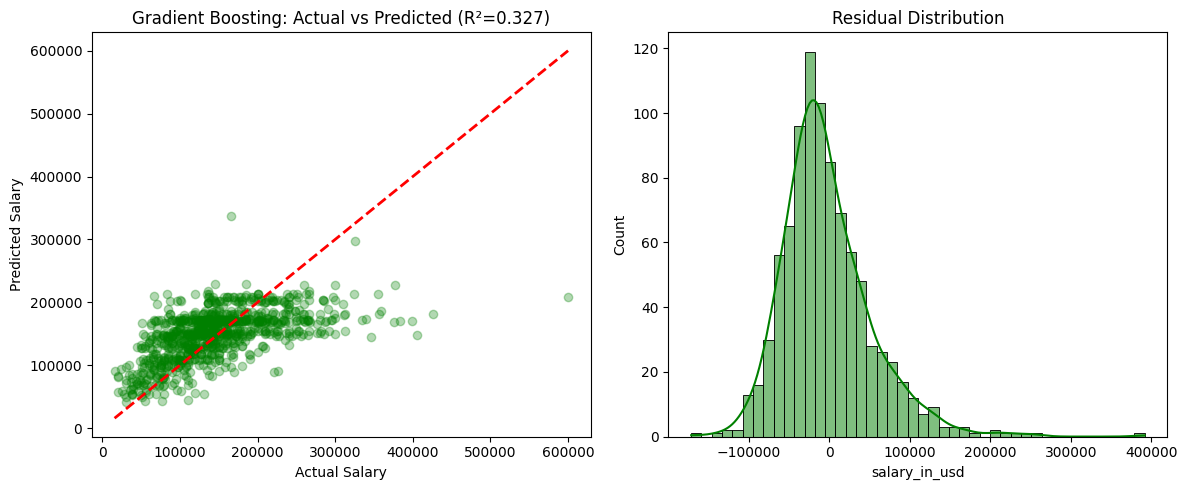

In [9]:
# ============================================================================
# PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE - FINAL)
# Research Topic: Optimizing Global Labor Costs Through Remote Work
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("="*80)
print("PART 3: DATA PREPARATION AND MODEL TRAINING (BEST PRACTICE - GRADIENT BOOSTING)")
print("="*80)

# ============================================================================
# SECTION 1: LOAD AND INITIAL CLEANING
# ============================================================================

# 1. Load Data
try:
    df = pd.read_csv('FoAI_A2_data_4.6k.csv')
    print(f"Dataset loaded: {len(df)} records")
except FileNotFoundError:
    print("Error: File not found. Please upload the dataset.")
    exit()

# 2. Basic Cleaning (Domain logic & Handling Data Issues)
# 2.1 Remove rows with missing essential targets
df = df.dropna(subset=['salary_in_usd', 'experience_level', 'company_size'])

# 2.2 Domain Knowledge Outlier Removal (Salary Range)
df = df[(df['salary_in_usd'] >= 10000) & (df['salary_in_usd'] <= 600000)]

# 2.3 Handling 'Hybrid' Data Issue (Sample size too small < 3%)
# Strategy: Focus analysis on the binary distinction between On-site (0) and Remote (100)
# to ensure statistical reliability.
rows_before_hybrid = len(df)
df = df[df['remote_ratio'].isin([0, 100])]
rows_after_hybrid = len(df)
print(f"Removed {rows_before_hybrid - rows_after_hybrid} Hybrid samples (remote_ratio=50).")

print(f"Data after cleaning: {len(df)} records")

# 3. Define Features and Target
target = 'salary_in_usd'
features = [
    'experience_level',     # Ordinal
    'company_size',         # Ordinal
    'remote_ratio',         # Numeric (Now effectively Binary: 0 or 100)
    'work_year',            # Numeric
    'employee_residence',   # Nominal (High Cardinality)
    'company_location',     # Nominal (High Cardinality)
    'job_title'             # Nominal (High Cardinality)
]

X = df[features]
y = df[target]

# ============================================================================
# SECTION 2: TRAIN-TEST SPLIT
# ============================================================================
# Critical: Split BEFORE encoding to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining Set: {len(X_train)} samples")
print(f"Test Set:     {len(X_test)} samples")

# ============================================================================
# SECTION 3: BUILD PIPELINE (FEATURE ENGINEERING)
# ============================================================================

# 1. Define transformers
# Ordinal: Explicit ordering for experience and size
experience_order = ['EN', 'MI', 'SE', 'EX']
company_size_order = ['S', 'M', 'L']

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[experience_order, company_size_order], 
                               handle_unknown='use_encoded_value', unknown_value=-1))
])

# Nominal: One-Hot Encoding with Rare Label Handling
# 'min_frequency=0.01' groups any category appearing in <1% of data into "infrequent_sklearn"
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
])

# Numeric: Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ['experience_level', 'company_size']),
        ('nom', nominal_transformer, ['job_title', 'employee_residence', 'company_location']),
        ('num', numeric_transformer, ['remote_ratio', 'work_year'])
    ],
    verbose_feature_names_out=False
)

# ============================================================================
# SECTION 4: MODEL DEFINITION (GRADIENT BOOSTING)
# ============================================================================

# Using GradientBoostingRegressor
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(
        n_estimators=300, 
        learning_rate=0.05, 
        max_depth=5, 
        random_state=42,
        validation_fraction=0.1, 
        n_iter_no_change=10      
    ))
])

print("\nTraining Gradient Boosting Pipeline...")
gb_pipeline.fit(X_train, y_train)
print("✓ Training complete.")

# ============================================================================
# SECTION 5: EVALUATION
# ============================================================================

print("\n" + "="*80)
print("MODEL EVALUATION (TEST SET)")
print("="*80)

y_pred = gb_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE (Root Mean Squared Error): ${rmse:,.0f}")
print(f"MAE (Mean Absolute Error):      ${mae:,.0f}")
print(f"R² (Variance Explained):        {r2:.4f}")
print(f"MAPE (Mean Abs % Error):        {mape:.2f}%")

# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title(f'Gradient Boosting: Actual vs Predicted (R²={r2:.3f})')

plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred, kde=True, color='green')
plt.title('Residual Distribution')
plt.tight_layout()
plt.savefig('model_evaluation_gb.png')
print("✓ Saved evaluation plot to 'model_evaluation_gb.png'")

# ============================================================================
# SECTION 6: PREDICTION FUNCTION
# ============================================================================

def make_prediction_gb(experience_level, remote_ratio, employee_residence, 
                       company_location, job_title, work_year, company_size):
    """
    Prediction function using the trained Gradient Boosting pipeline.
    """
    input_data = pd.DataFrame({
        'experience_level': [experience_level],
        'remote_ratio': [remote_ratio],
        'employee_residence': [employee_residence],
        'company_location': [company_location],
        'job_title': [job_title],
        'work_year': [work_year],
        'company_size': [company_size]
    })
    
    prediction = gb_pipeline.predict(input_data)[0]
    return prediction

# ============================================================================
# SECTION 7: RESEARCH QUESTIONS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("RESEARCH QUESTIONS ANALYSIS (GRADIENT BOOSTING RESULTS)")
print("="*80)

# RQ1: Remote Work Impact
print("\n--- RQ1: Remote Work Impact (Mid-level Data Scientist, US) ---")
p1_onsite = make_prediction_gb('MI', 0, 'US', 'US', 'Data Scientist', 2024, 'M')
p1_remote = make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
print(f"On-site: ${p1_onsite:,.0f}")
print(f"Remote:  ${p1_remote:,.0f}")
print(f"Impact:  {((p1_remote - p1_onsite)/p1_onsite)*100:.1f}%")

# RQ2: Geographic Arbitrage
print("\n--- RQ2: Geographic Arbitrage (Mid-level Data Scientist, Remote) ---")
p2_us = make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
p2_in = make_prediction_gb('MI', 100, 'IN', 'US', 'Data Scientist', 2024, 'M') # India
p2_pl = make_prediction_gb('MI', 100, 'PL', 'US', 'Data Scientist', 2024, 'M') # Poland
print(f"US Based:     ${p2_us:,.0f}")
print(f"India Based:  ${p2_in:,.0f} (Savings: {((p2_us - p2_in)/p2_us)*100:.1f}%)")
print(f"Poland Based: ${p2_pl:,.0f} (Savings: {((p2_us - p2_pl)/p2_us)*100:.1f}%)")

# RQ3: Team Composition
print("\n--- RQ3: Team Composition (1 Senior vs 2 Mids) ---")
p3_senior = make_prediction_gb('SE', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
p3_mid = make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M')
print(f"Option A (1 Senior): ${p3_senior:,.0f}")
print(f"Option B (2 Mids):   ${p3_mid * 2:,.0f}")

# RQ4: Total Optimization Strategy
print("\n--- RQ4: Total Optimization Strategy ---")
# Baseline: 10 Local US Employees (Traditional = On-site)
# NOTE: Changed Mid-level from remote_ratio=50 to 0 to align with clean data (On-site vs Remote)
cost_baseline = (2 * make_prediction_gb('SE', 0, 'US', 'US', 'Data Scientist', 2024, 'M') +
                 6 * make_prediction_gb('MI', 0, 'US', 'US', 'Data Scientist', 2024, 'M') +
                 2 * make_prediction_gb('EN', 0, 'US', 'US', 'Data Analyst', 2024, 'M'))

# Optimized: Global Remote Team
cost_optimized = (1 * make_prediction_gb('SE', 100, 'US', 'US', 'Data Scientist', 2024, 'M') +
                  1 * make_prediction_gb('SE', 100, 'PL', 'US', 'Data Scientist', 2024, 'M') + 
                  3 * make_prediction_gb('MI', 100, 'US', 'US', 'Data Scientist', 2024, 'M') +
                  3 * make_prediction_gb('MI', 100, 'IN', 'US', 'Data Scientist', 2024, 'M') + 
                  2 * make_prediction_gb('EN', 100, 'IN', 'US', 'Data Analyst', 2024, 'M'))    

print(f"Baseline Cost:  ${cost_baseline:,.0f}")
print(f"Optimized Cost: ${cost_optimized:,.0f}")
print(f"Total Savings:  ${cost_baseline - cost_optimized:,.0f} ({((cost_baseline - cost_optimized)/cost_baseline)*100:.1f}%)")

# Save model
joblib.dump(gb_pipeline, 'salary_pipeline_gb_best.pkl')
print("\n✓ Gradient Boosting pipeline saved to 'salary_pipeline_gb_best.pkl'")